In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_parquet("data/chess_game_0001.parquet")
df = df.iloc[:100_000]
df.head()

,Moves,Termination,Result
0,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d...",FIVEFOLD_REPETITION,1/2-1/2
1,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c...",CHECKMATE,1-0
2,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c...",INSUFFICIENT_MATERIAL,1/2-1/2
3,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g...",CHECKMATE,1-0
4,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c...",CHECKMATE,1-0


(array([1.000e+00, 2.000e+00, 7.200e+01, 9.900e+01, 2.340e+02, 3.350e+02,
        5.900e+02, 1.005e+03, 1.427e+03, 2.279e+03, 2.547e+03, 3.214e+03,
        3.904e+03, 5.055e+03, 5.225e+03, 5.726e+03, 5.839e+03, 5.810e+03,
        6.229e+03, 4.986e+03, 4.220e+03, 3.678e+03, 3.583e+03, 2.763e+03,
        2.406e+03, 2.192e+03, 2.013e+03, 2.156e+03, 1.873e+03, 1.689e+03,
        1.691e+03, 1.816e+03, 1.562e+03, 1.503e+03, 1.297e+03, 1.098e+03,
        1.208e+03, 9.470e+02, 8.940e+02, 8.190e+02, 7.700e+02, 6.350e+02,
        5.220e+02, 4.510e+02, 4.580e+02, 4.720e+02, 3.040e+02, 3.320e+02,
        2.730e+02, 2.460e+02, 1.790e+02, 1.450e+02, 1.690e+02, 1.280e+02,
        1.320e+02, 9.800e+01, 6.900e+01, 7.700e+01, 5.700e+01, 7.000e+01,
        5.400e+01, 4.700e+01, 4.600e+01, 2.900e+01, 3.100e+01, 2.700e+01,
        2.400e+01, 2.500e+01, 1.900e+01, 1.500e+01, 1.800e+01, 1.700e+01,
        1.200e+01, 7.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 2.000e+00,
        6.000e+00, 4.000e+00, 1.000e+0

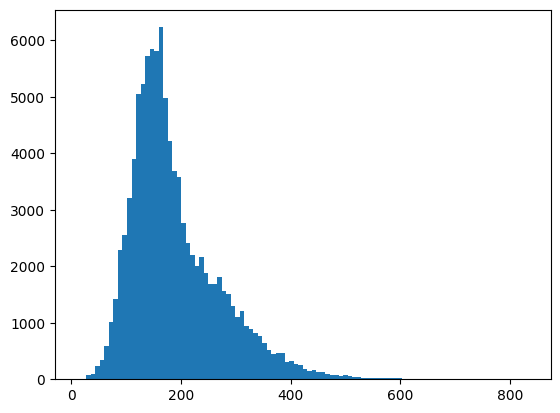

In [3]:
lengths = df.copy()
lengths["Moves"] = df["Moves"].apply(lambda x: len(x)) 
plt.hist(lengths["Moves"], 100)

Text(0.5, 1.0, 'Result')

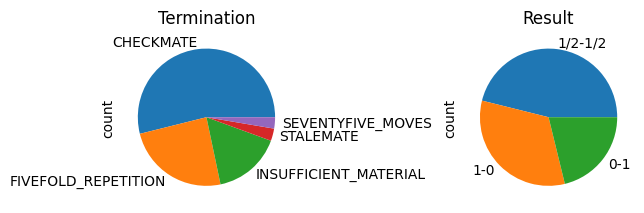

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
df["Termination"].value_counts().plot.pie(ax=ax1)
df["Result"].value_counts().plot.pie(ax=ax2)
fig.tight_layout()

ax1.set_title("Termination")
ax2.set_title("Result")

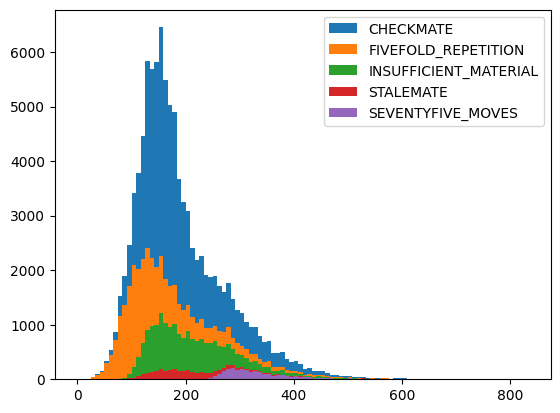

In [9]:
fig, ax = plt.subplots()            

bins = np.linspace(0, max(lengths["Moves"]), 100 + 1)
bin_width = bins[1]
counts = []
labels = []
n_labels = len(lengths["Termination"].unique())
bar_width = bin_width / n_labels
for idx, (label, group) in enumerate(lengths.groupby("Termination")):
    count, _ = np.histogram(group["Moves"], bins=bins)
    counts.append(count)
    labels.append(label)                    
    #   ax.bar(bins[:-1] + bar_width / 2 + idx * bar_width, count, bar_width)
counts = np.stack(counts)
sort_idx = np.argsort(counts.sum(axis=1))
counts = counts[sort_idx]
labels = np.array(labels)[sort_idx]

for count, label in zip(counts.cumsum(axis=0)[::-1], labels[::-1]):
    ax.bar(bins[:-1] + bin_width / 2, count, width=bin_width, label=label)
    
ax.legend()
                

In [ ]:
del lengths

In [10]:
start_pos = np.zeros((8, 8), dtype=int)
end_pos = np.zeros((8, 8), dtype=int)
captured_pieces = []
pieces = "kqbnrp"
capture_pos = np.zeros((len(pieces), 8, 8), dtype=int)
for move in tqdm(np.concat(df["Moves"].values)):
    start_pos[ord(move[0]) - ord("a"), int(move[1]) - 1] += 1
    end_pos[ord(move[2]) - ord("a"), int(move[3]) - 1] += 1
        
    if len(move) == 5:
        captured_pieces.append(move[4])
        capture_pos[pieces.find(move[4]), ord(move[2]) - ord("a"), int(move[3]) - 1] += 1

  0%|          | 0/18951733 [00:00<?, ?it/s]

100%|██████████| 18951733/18951733 [00:18<00:00, 1012599.53it/s]


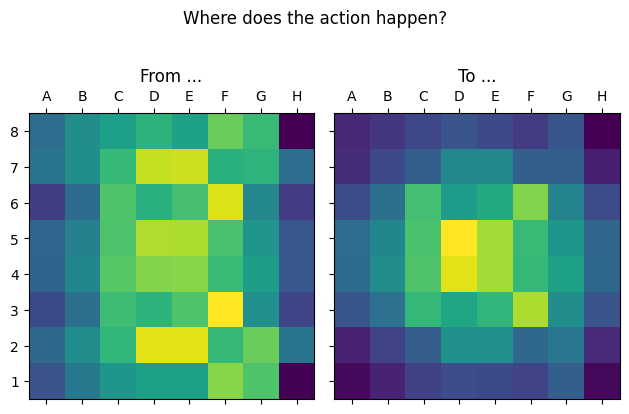

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.matshow(start_pos.T)
ax2.matshow(end_pos.T)

fig.suptitle("Where does the action happen?")
ax1.set_title("From ...")
ax2.set_title("To ...")

ax1.set_yticks(np.arange(8), np.arange(8)[::-1] + 1)
ax1.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
ax2.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
fig.tight_layout()

<Axes: >

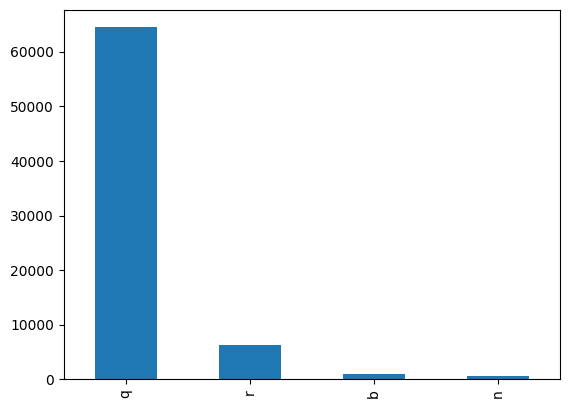

In [ ]:
pd.Series(captured_pieces).value_counts().plot.bar()        

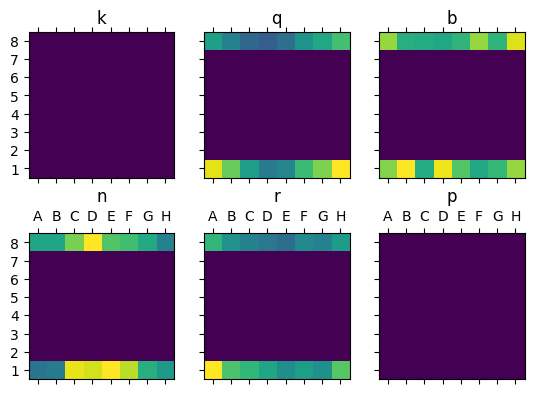

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True)

for idx, ax in enumerate(axs.flatten()):
    ax.set_title(pieces[idx])
    ax.matshow(capture_pos[idx].T)
    ax.set_yticks(np.arange(8), np.arange(8)[::-1] + 1)
    ax.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])


In [ ]:
start_pos = np.zeros((8, 8), dtype=int)
end_pos = np.zeros((8, 8), dtype=int)
captured_pieces = []
pieces = "kqbnrp"
capture_pos = np.zeros((len(pieces), 8, 8), dtype=int)
for move in tqdm(df["Moves"]):
    move = move[0]
    start_pos[ord(move[0]) - ord("a"), int(move[1]) - 1] += 1
    end_pos[ord(move[2]) - ord("a"), int(move[3]) - 1] += 1
        
    if len(move) == 5:
        captured_pieces.append(move[4])
        capture_pos[pieces.find(move[4]), ord(move[2]) - ord("a"), int(move[3]) - 1] += 1

 21%|██        | 20926/100000 [00:00<00:00, 101452.00it/s]

d2d4
e2e4
d2d4
c2c4
d2d4
e2e4
d2d4
g1f3
g1f3
d2d4
c2c4
e2e4
g1f3
e2e4
d2d4
g1f3
e2e4
e2e4
e2e4
d2d4
g1f3
c2c4
e2e4
d2d4
d2d4
g1f3
d2d4
d2d4
d2d4
d2d4
d2d4
e2e4
d2d4
e2e4
d2d4
d2d4
e2e4
g1f3
e2e4
d2d4
d2d4
e2e4
e2e4
g1f3
e2e4
d2d4
e2e4
d2d4
c2c4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
d2d4
d2d4
c2c4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
g1f3
e2e4
c2c4
d2d4
e2e4
g1f3
g1f3
e2e4
d2d4
d2d4
e2e4
c2c4
d2d4
d2d4
d2d4
c2c4
d2d4
d2d4
d2d4
d2d4
e2e4
c2c4
e2e4
g1f3
g1f3
d2d4
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
d2d4
e2e4
g1f3
c2c4
g1f3
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
g1f3
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
d2d4
g1f3
c2c4
g1f3
e2e4
e2e4
e2e4
d2d4
e2e4
g1f3
g1f3
e2e4
d2d4
e2e4
d2d4
g1f3
e2e4
d2d4
c2c4
d2d4
d2d4
g1f3
e2e4
e2e4
g1f3
d2d4
g1f3
e2e4
g1f3
c2c4
e2e4
c2c4
d2d4
e2e4
d2d4
e2e4
c2c4
e2e4
e2e4
e2e4
d2d4
e2e4
d2d4
d2d4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
g1f3
e2e4
c2c4
e2e4
e2e4
d2d4
d2d4
d2d4
g1f3
d2d4
e2e4
c2c4
e2e4
d2d4
e2e4
g1f3
d2d4
e2e4
e2e4
e2e4
d2d4
g1f3
d2d4
e2e4
e2e4
d2d4
d2d4
c2c4
e2e4


 44%|████▍     | 44126/100000 [00:00<00:00, 110761.51it/s]

e2e4
e2e4
e2e4
g1f3
g1f3
d2d4
e2e4
c2c4
e2e4
d2d4
e2e4
g1f3
d2d4
d2d4
e2e4
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
d2d4
d2d4
e2e4
g1f3
e2e4
d2d4
e2e4
d2d4
e2e4
d2d4
d2d4
d2d4
e2e4
e2e4
c2c4
e2e4
e2e4
d2d4
e2e4
d2d4
e2e4
e2e4
c2c4
d2d4
d2d4
c2c4
g1f3
e2e4
e2e4
d2d4
g1f3
e2e4
d2d4
d2d4
d2d4
e2e4
d2d4
d2d4
e2e4
d2d4
d2d4
d2d4
e2e4
e2e4
d2d4
d2d4
e2e4
e2e4
d2d4
d2d4
e2e4
e2e4
d2d4
d2d4
e2e4
c2c4
d2d4
e2e4
g2g3
e2e4
d2d4
e2e4
d2d4
d2d4
d2d4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
c2c4
e2e4
e2e4
d2d4
c2c4
e2e4
e2e4
c2c4
g2g3
g1f3
d2d4
e2e4
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
e2e4
d2d4
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
d2d4
d2d4
e2e4
e2e4
g1f3
d2d4
e2e4
d2d4
e2e4
g1f3
g1f3
d2d4
e2e4
d2d4
d2d4
e2e4
g2g3
c2c4
d2d4
d2d4
e2e4
d2d4
d2d4
e2e4
e2e4
d2d4
c2c4
e2e4
c2c4
d2d4
e2e4
d2d4
c2c4
g1f3
f2f4
e2e4
e2e4
e2e4
d2d4
d2d4
c2c4
d2d4
e2e4
e2e4
d2d4
g1f3
c2c4
e2e4
c2c4
d2d4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
g1f3
e2e4
e2e4
g1f3
e2e4
e2e4
c2c4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4


 69%|██████▉   | 68808/100000 [00:00<00:00, 118085.00it/s]

d2d4
d2d4
d2d4
e2e4
e2e4
g1f3
g1f3
d2d4
d2d4
e2e4
e2e4
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
e2e4
g1f3
c2c4
e2e4
c2c4
g2g3
e2e4
d2d4
e2e4
g1f3
g2g3
e2e4
g1f3
d2d4
e2e4
e2e4
g1f3
d2d4
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
c2c4
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
d2d4
c2c4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
g1f3
d2d4
e2e4
g1f3
d2d4
d2d4
d2d4
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
d2d4
d2d4
e2e4
c2c4
d2d4
d2d4
g1f3
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
g1f3
e2e4
c2c4
d2d4
e2e4
d2d4
e2e4
e2e4
c2c4
f2f4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
g1f3
c2c4
d2d4
d2d4
d2d4
e2e4
e2e4
d2d4
d2d4
e2e4
d2d4
e2e4
d2d4
e2e4
b2b3
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
c2c4
c2c4
c2c4
d2d4
e2e4
d2d4
e2e4
e2e4
c2c4
d2d4
d2d4
e2e4
d2d4
d2d4
d2d4
d2d4
e2e4
d2d4
g1f3
d2d4
e2e4
c2c4
e2e4
d2d4
c2c4
e2e4
e2e4
e2e4
d2d4
g2g3
d2d4
e2e4
d2d4
d2d4
e2e4
e2e4
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
c2c4
e2e4
e2e4
d2d4
d2d4
g1f3
d2d4
d2d4
d2d4
e2e4
d2d4
e2e4
d2d4
d2d4
g1f3
e2e4
g1f3
e2e4
e2e4
e2e4
d2d4
d2d4
e2e4
e2e4


100%|██████████| 100000/100000 [00:00<00:00, 115162.89it/s]


e2e4
g1f3
d2d4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
g2g4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
d2d4
d2d4
d2d4
d2d4
e2e4
d2d4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
d2d4
e2e4
d2d4
d2d4
d2d4
e2e4
g1f3
e2e4
d2d4
e2e4
d2d4
e2e4
d2d4
e2e4
d2d4
g1f3
e2e4
d2d4
e2e4
c2c4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
g1f3
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
g1f3
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
e2e4
d2d4
d2d4
d2d4
e2e4
d2d4
d2d4
e2e4
e2e4
d2d4
b2b3
g1f3
d2d4
e2e4
g1f3
d2d4
g1f3
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
d2d4
c2c4
d2d4
e2e4
d2d4
g1f3
c2c4
e2e4
e2e4
d2d4
e2e4
b2b3
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
g1f3
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
d2d4
d2d4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
b2b4
d2d4
g1f3
e2e4
e2e4
d2d4
e2e4
e2e4
e2e4
e2e4
b1c3
e2e4
d2d4
e2e4
e2e4
g1f3
c2c4
e2e4
e2e4
d2d4
d2d4
d2d4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
e2e4
d2d4
e2e4
e2e4
g1f3
d2d4
g1f3
e2e4
e2e4
d2d4
e2e4
d2d4
e2e4
g1f3
e2e4
c2c4
e2e4
d2d4
g1f3
d2d4
d2d4
e2e4
d2d4
c2c4
d2d4
d2d4
c2c4
d2d4
e2e4
e2e4
d2d4
e2e4
e2e4

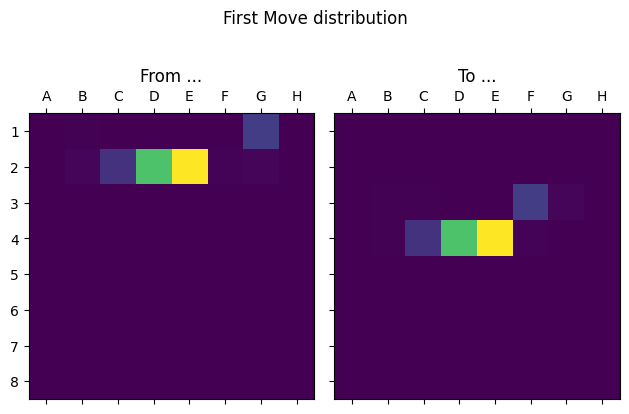

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.matshow(start_pos.T)
ax2.matshow(end_pos.T)

fig.suptitle("First Move distribution")
ax1.set_title("From ...")   
ax2.set_title("To ...")

ax1.set_yticks(np.arange(8), np.arange(8) + 1)
ax1.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
ax2.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
fig.tight_layout()